### Libraries

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statistics
import scipy.stats
from statistics import NormalDist
from scipy.stats import gaussian_kde
from scipy.stats import shapiro,jarque_bera
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import shapiro

### Data

Read the CSV file as nyc_prop

In [129]:
nyc_prop = pd.read_csv("E:/Python/Stupen-Hacktiv8/nyc-rolling-sales.csv")
nyc_prop.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


### Cleaning Data
Make a copy of the original data first by defining it as *df*, so the original data is not corrupt

In [130]:
df = nyc_prop.copy()

Remove irrelevant columns, lower the columns' names, and also replace the blankspace with underscores.

In [131]:
df=df.drop(["Unnamed: 0"],axis=1)
df.columns = (df.columns.str.lower()).str.replace(" ","_")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   borough                         84548 non-null  int64 
 1   neighborhood                    84548 non-null  object
 2   building_class_category         84548 non-null  object
 3   tax_class_at_present            84548 non-null  object
 4   block                           84548 non-null  int64 
 5   lot                             84548 non-null  int64 
 6   ease-ment                       84548 non-null  object
 7   building_class_at_present       84548 non-null  object
 8   address                         84548 non-null  object
 9   apartment_number                84548 non-null  object
 10  zip_code                        84548 non-null  int64 
 11  residential_units               84548 non-null  int64 
 12  commercial_units                84548 non-null

Convert all to numeric variables by defining *num*

In [132]:
num = ["residential_units","commercial_units","total_units","land_square_feet","gross_square_feet","year_built","sale_price"]
for col in num: 
    df[col] = pd.to_numeric(df[col], errors='coerce')

Convert all to categorical variables and change them to object

In [133]:
cat_columns = []
for col in df.columns[:-1]:
    if col not in num:
        cat_columns.append(col)
        
for col in cat_columns:
    df[col] = df[col].astype("object")

Change *sale_datetime* to datetime

In [134]:
df["sale_date"] = pd.to_datetime(df["sale_date"])

According to the data, each borough would be renamed and represented by number :
- 1 = Manhattam
- 2 = Bronx
- 3 = Brooklyn
- 4 = Queens
- 5 = Staten Island

In [135]:
def renaming_borough(x):
    if x == 1:
        return "Manhattan"
    elif x == 2:
        return "Bronx"
    elif x == 3:
        return "Brooklyn"
    elif x == 4:
        return "Queens"
    else:
        return "Staten Island"
    
df["borough"] = df["borough"].apply(renaming_borough)
df.head()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,ease-ment,building_class_at_present,address,apartment_number,...,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date
0,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,...,5,0,5,1633.0,6440.0,1900,2,C2,6625000.0,2017-07-19
1,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,...,28,3,31,4616.0,18690.0,1900,2,C7,NaN,2016-12-14
2,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,...,16,1,17,2212.0,7803.0,1900,2,C7,NaN,2016-12-09
3,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,...,10,0,10,2272.0,6794.0,1913,2,C4,3936272.0,2016-09-23
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,...,6,0,6,2369.0,4615.0,1900,2,C2,8000000.0,2016-11-17


Replace blankspace with NaN, then count the percentage of missing values.

In [136]:
df.replace(' ',np.nan, inplace=True)
df.isna().sum() /len(df) *100

borough                             0.000000
neighborhood                        0.000000
building_class_category             0.000000
tax_class_at_present                0.872877
block                               0.000000
lot                                 0.000000
ease-ment                         100.000000
building_class_at_present           0.872877
address                             0.000000
apartment_number                   77.466055
zip_code                            0.000000
residential_units                   0.000000
commercial_units                    0.000000
total_units                         0.000000
land_square_feet                   31.049818
gross_square_feet                  32.658372
year_built                          0.000000
tax_class_at_time_of_sale           0.000000
building_class_at_time_of_sale      0.000000
sale_price                         17.222170
sale_date                           0.000000
dtype: float64

Count the missing values

In [137]:
df.isna().sum()

borough                               0
neighborhood                          0
building_class_category               0
tax_class_at_present                738
block                                 0
lot                                   0
ease-ment                         84548
building_class_at_present           738
address                               0
apartment_number                  65496
zip_code                              0
residential_units                     0
commercial_units                      0
total_units                           0
land_square_feet                  26252
gross_square_feet                 27612
year_built                            0
tax_class_at_time_of_sale             0
building_class_at_time_of_sale        0
sale_price                        14561
sale_date                             0
dtype: int64

Drop irrelevant columns

In [138]:
df = df.drop(["ease-ment","apartment_number", "block", "lot", "address"],axis=1)

Drop NaN values from *tax_class_at_present* and *building_class_at_present* columns

In [139]:
df = df.dropna(subset=["tax_class_at_present","building_class_at_present"])

Change NaN values by 0 in *land_square_feet* and *sale_price* columns

In [140]:
for i in ["land_square_feet","gross_square_feet","sale_price"]:
    df[i] = df[i].fillna(0)

Take a sale price is greater than 0

In [141]:
df = df[df["sale_price"] != 0]
df

,borough,neighborhood,building_class_category,tax_class_at_present,building_class_at_present,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date
0,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,C2,10009,5,0,5,1633.0,6440.0,1900,2,C2,6625000.0,2017-07-19
3,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,10009,10,0,10,2272.0,6794.0,1913,2,C4,3936272.0,2016-09-23
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,C2,10009,6,0,6,2369.0,4615.0,1900,2,C2,8000000.0,2016-11-17
6,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,10009,8,0,8,1750.0,4226.0,1920,2,C4,3192840.0,2016-09-23
9,Manhattan,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,D9,10009,24,0,24,4489.0,18523.0,1920,2,D9,16232000.0,2016-11-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,Staten Island,WOODROW,02 TWO FAMILY DWELLINGS,1,B9,10309,2,0,2,2400.0,2575.0,1998,1,B9,450000.0,2016-11-28
84544,Staten Island,WOODROW,02 TWO FAMILY DWELLINGS,1,B9,10309,2,0,2,2498.0,2377.0,1998,1,B9,550000.0,2017-04-21
84545,Staten Island,WOODROW,02 TWO FAMILY DWELLINGS,1,B2,10309,2,0,2,4000.0,1496.0,1925,1,B2,460000.0,2017-07-05
84546,Staten Island,WOODROW,22 STORE BUILDINGS,4,K6,10309,0,7,7,208033.0,64117.0,2001,4,K6,11693337.0,2016-12-21


Group all the sub-classess into 4 main classess

In [142]:
df["building_class_at_present"] = df["building_class_at_present"].str[0]
df.head()

,borough,neighborhood,building_class_category,tax_class_at_present,building_class_at_present,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date
0,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,C,10009,5,0,5,1633.0,6440.0,1900,2,C2,6625000.0,2017-07-19
3,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C,10009,10,0,10,2272.0,6794.0,1913,2,C4,3936272.0,2016-09-23
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,C,10009,6,0,6,2369.0,4615.0,1900,2,C2,8000000.0,2016-11-17
6,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C,10009,8,0,8,1750.0,4226.0,1920,2,C4,3192840.0,2016-09-23
9,Manhattan,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,D,10009,24,0,24,4489.0,18523.0,1920,2,D9,16232000.0,2016-11-07


Take the years from *sale_date* column and assign it to a new column called *year*

In [143]:
df["year"] = [i.year for i in df["sale_date"]]

Check if the dataset still has any NaN values.

In [144]:
df.isnull().sum().sum()

0

We can use box plot to check if the dataset still has any outliers. Based on the boxplot, we can see that there's a lot of outliers

c:\Users\acer_\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


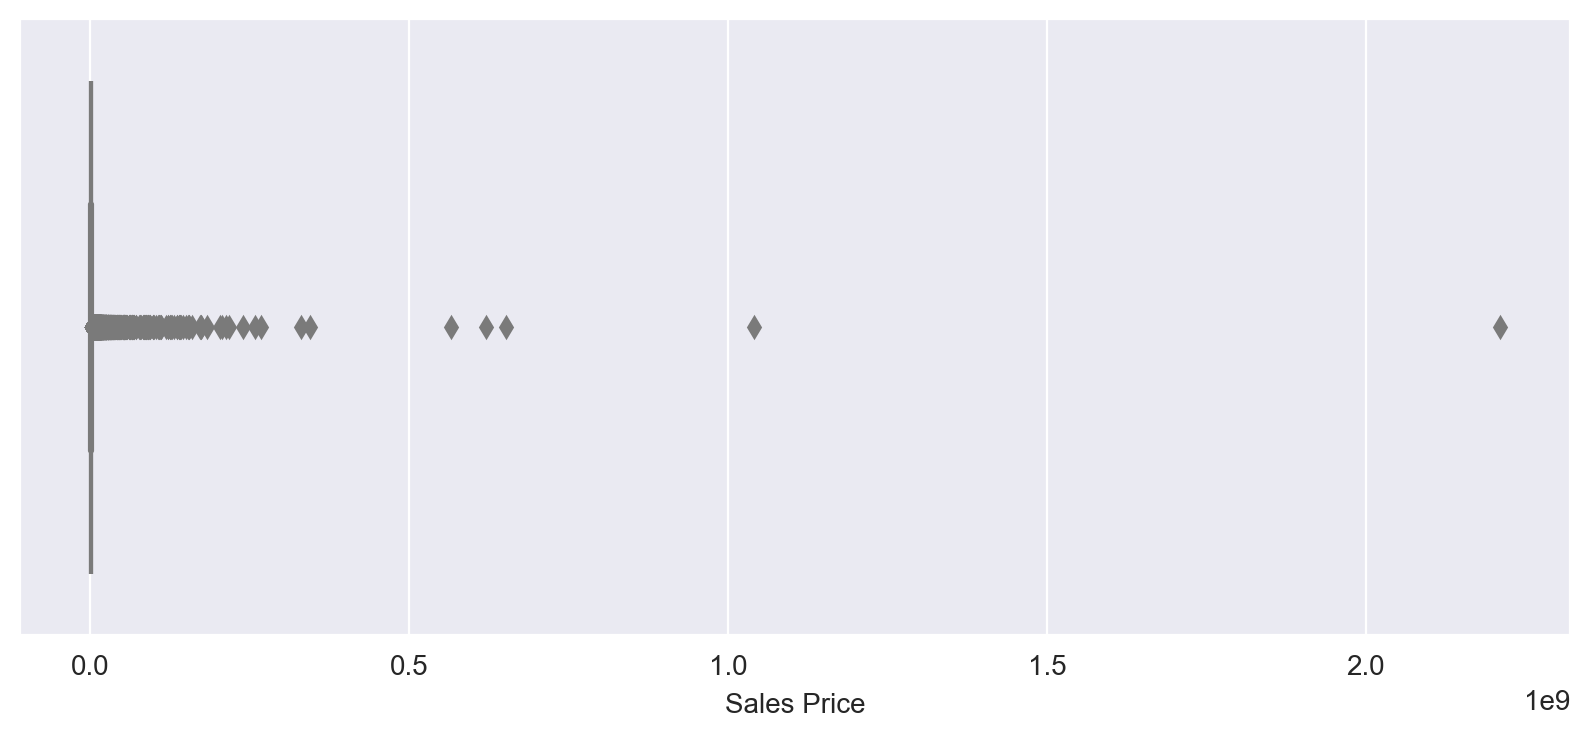

In [145]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,4),dpi=200)
    sns.boxplot(data=df,x="sale_price",color=sns.color_palette("Pastel1")[1])
    plt.xlabel("Sales Price")
    plt.show()

Because the dataset still has any outliers, we should remove outliers with IQR method
- Calculate the first and third quartile (Q1 and Q3)
- Evaluate the interquartile range where IQR = Q3 - Q1
- Estimate the lower limit where the lower limit = Q1 - (1.5 × IQR)
- Estimate the upper limit where the upper limit = Q3 + (1.5 × IQR)
- Select rows where the sale_price is between the lower and upper limits

And define it by *outliers_removed*.

In [146]:
sale_price_q1 = df["sale_price"].describe().loc["25%"]
sale_price_q3 = df["sale_price"].describe().loc["75%"]
sale_price_iqr = sale_price_q3 - sale_price_q1

sale_price_lower_limit = sale_price_q1 - (1.5 * sale_price_iqr)
sale_price_upper_limit = sale_price_q3 + (1.5 * sale_price_iqr)

In [147]:
outliers_removed = df[(df["sale_price"] >= sale_price_lower_limit) & (df["sale_price"] <= sale_price_upper_limit)]
outliers_removed.head()

,borough,neighborhood,building_class_category,tax_class_at_present,building_class_at_present,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date,year
12,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C,10009,0,0,0,0.0,0.0,1920,2,C6,1.0,2016-09-06,2016
13,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C,10009,0,0,0,0.0,0.0,1920,2,C6,499000.0,2017-03-10,2017
14,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C,10009,0,0,0,0.0,0.0,1920,2,C6,10.0,2017-04-28,2017
15,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C,10009,0,0,0,0.0,0.0,1920,2,C6,529500.0,2017-06-09,2017
16,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C,10009,0,0,0,0.0,0.0,1920,2,C6,423000.0,2017-07-14,2017


Let's recheck if the dataset still has any outliers. Apparently, there are still some outliers.

c:\Users\acer_\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'Sales Price')

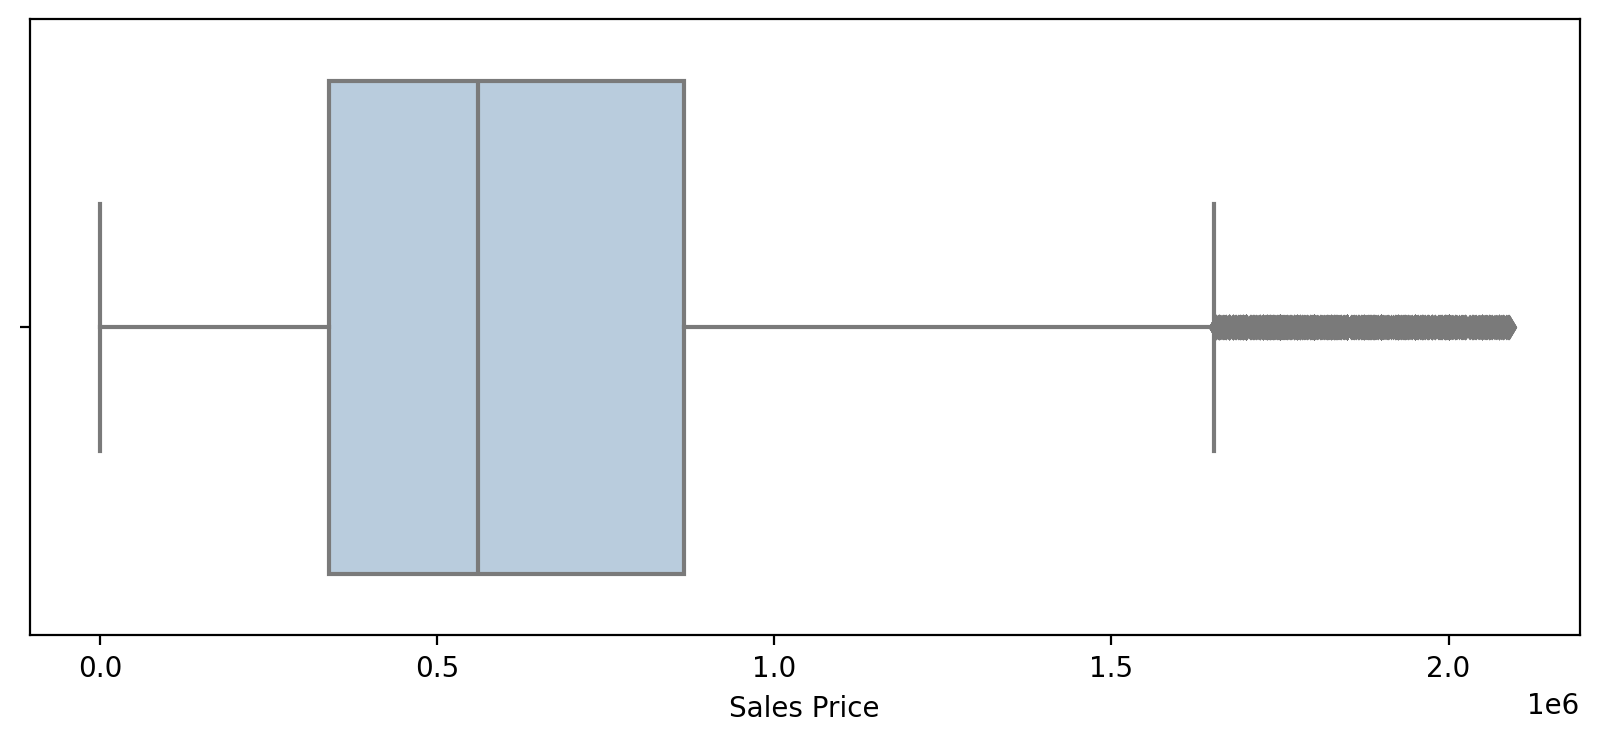

In [148]:
plt.figure(figsize=(10,4),dpi=200)
sns.boxplot(data=outliers_removed,x="sale_price", color=sns.color_palette("Pastel1")[1])
plt.xlabel("Sales Price")

Repeat the step above as much as needed.

In [149]:
n = 1
limit = 2

while n <= limit:
    sale_price_q1 = outliers_removed["sale_price"].describe().loc["25%"]
    sale_price_q3 = outliers_removed["sale_price"].describe().loc["75%"]
    sale_price_iqr = sale_price_q3 - sale_price_q1

    sale_price_lower_limit = sale_price_q1 - (1.5 * sale_price_iqr)
    sale_price_upper_limit = sale_price_q3 + (1.5 * sale_price_iqr)

    outliers_removed = outliers_removed[(outliers_removed["sale_price"] >= sale_price_lower_limit) & (outliers_removed["sale_price"] <= sale_price_upper_limit)]
    
    n += 1

Let's recheck if the dataset still has any outliers.

c:\Users\acer_\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'Sales Price')

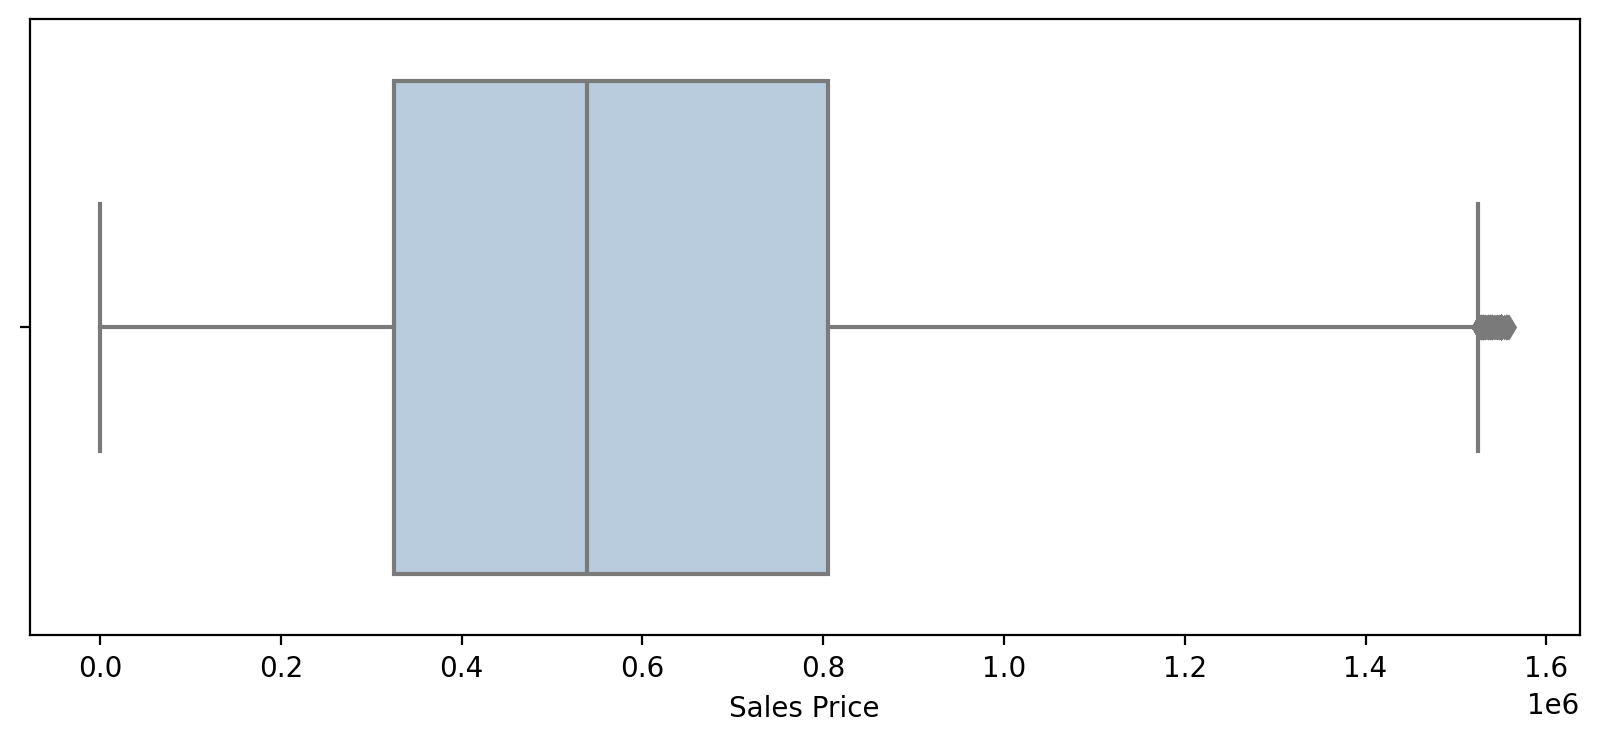

In [150]:
plt.figure(figsize=(10,4),dpi=200)
sns.boxplot(data=outliers_removed,x="sale_price", color=sns.color_palette("Pastel1")[1])
plt.xlabel("Sales Price")

### Measures of Central Tendency

Calculate measures of central tendency by every *borough* and *tax_class_at_present*, such as:

- Mean
- Median
- Mode
- Range
- Variance
- Standard Deviation

If there are NaN values, it means that there's only a single value within that *borough* and *tax_class_at_present*, so let's drop all of the NaN values.

In [151]:
mct = outliers_removed.groupby(["borough","building_class_at_present","year"]).agg({"sale_price":[np.mean,
                                                                                    np.median,
                                                                                    statistics.mode,
                                                                                   np.ptp,
                                                                                   np.var,
                                                                                   np.std]})
mct = mct.reset_index()
mct.columns = mct.columns.droplevel(-1)
mct.columns = ['borough','building_class_at_present','year','mean','median','mode','range','variance','standard_deviation']
mct = mct.dropna()
mct

C:\Users\acer_\AppData\Local\Temp\ipykernel_812\2569010846.py:1: FutureWarning: The provided callable <function mean at 0x0000025F709E8A40> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  mct = outliers_removed.groupby(["borough","building_class_at_present","year"]).agg({"sale_price":[np.mean,
C:\Users\acer_\AppData\Local\Temp\ipykernel_812\2569010846.py:1: FutureWarning: The provided callable <function median at 0x0000025F7EB14860> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  mct = outliers_removed.groupby(["borough","building_class_at_present","year"]).agg({"sale_price":[np.mean,
C:\Users\acer_\AppData\Local\Temp\ipykernel_812\2569010846.py:1: FutureWarning: The provided callable <function var at 0x0000025F709E8CC0> is currently 

,borough,building_class_at_present,year,mean,median,mode,range,variance,standard_deviation
0,Bronx,A,2016,396286.338843,390000.0,400000.0,1449999.0,3.171911e+10,178098.583630
1,Bronx,A,2017,404989.838760,402500.0,10.0,1393498.0,3.702816e+10,192427.030941
2,Bronx,B,2016,452286.957265,470000.0,475000.0,899999.0,2.763996e+10,166252.708328
3,Bronx,B,2017,471981.260820,493395.0,550000.0,1549999.0,3.656647e+10,191223.603040
4,Bronx,C,2016,502421.931727,519000.0,625000.0,1549990.0,8.539886e+10,292230.828235
...,...,...,...,...,...,...,...,...,...
157,Staten Island,S,2017,395919.724138,402000.0,25000.0,900000.0,5.248968e+10,229106.270267
158,Staten Island,V,2016,357785.695652,280000.0,650000.0,1265000.0,1.079070e+11,328492.016367
159,Staten Island,V,2017,332461.133333,295292.0,350000.0,1199990.0,7.792322e+10,279147.313163
160,Staten Island,W,2016,1.000000,1.0,1.0,0.0,0.000000e+00,0.000000


Visualize the mean of sale_price from the building_at_present category in every borough.

c:\Users\acer_\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\acer_\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\acer_\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


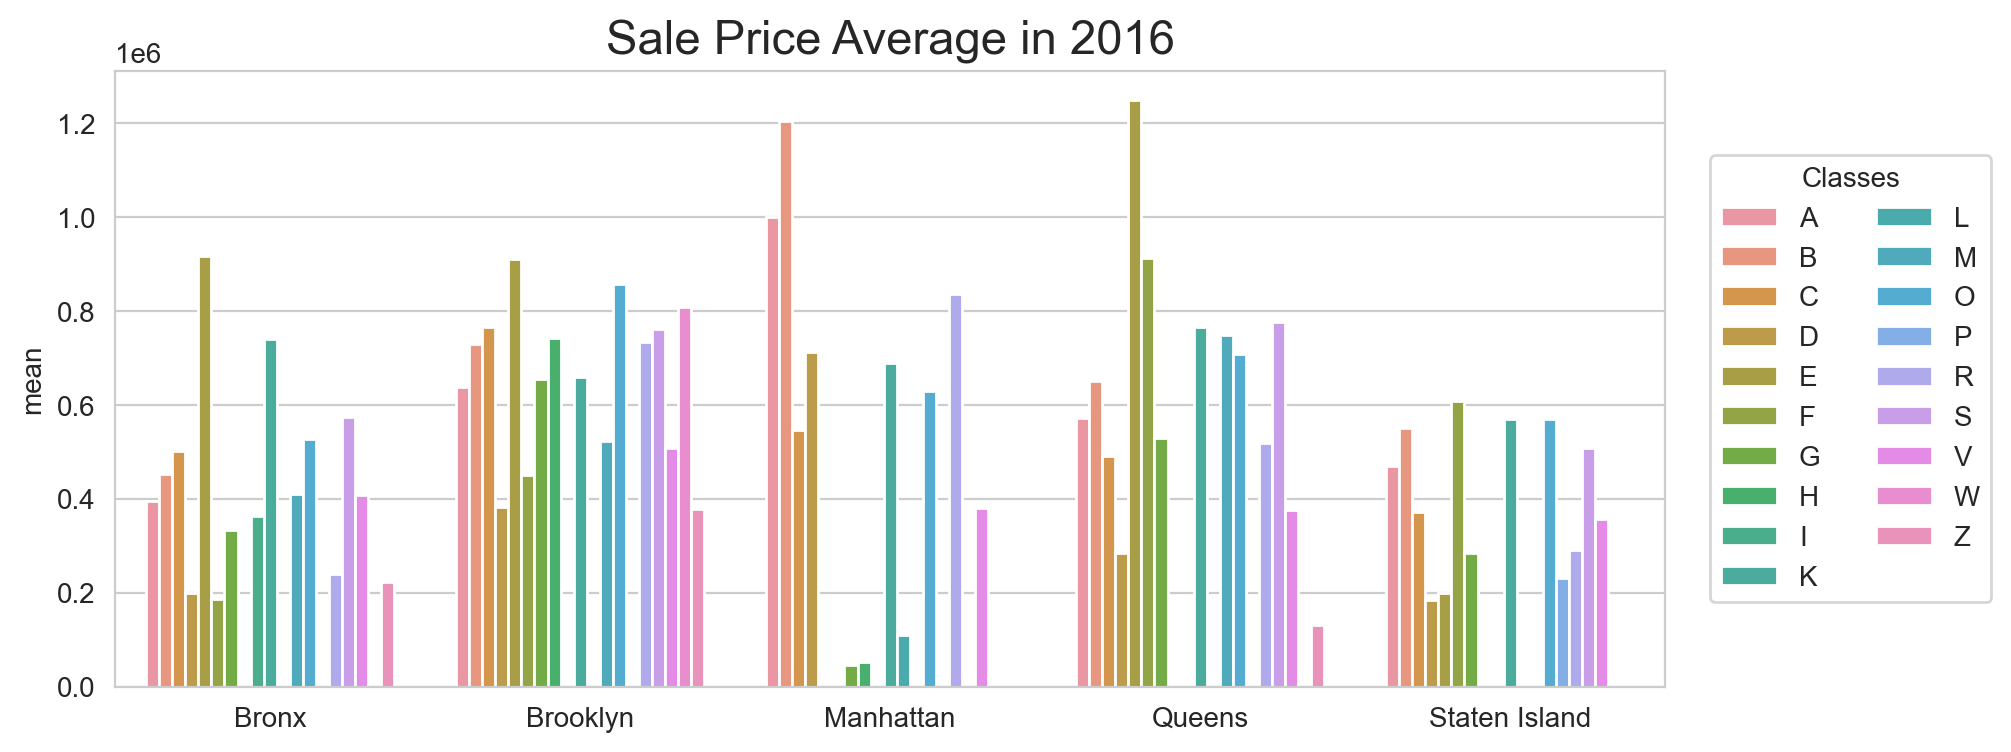

c:\Users\acer_\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\acer_\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\acer_\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


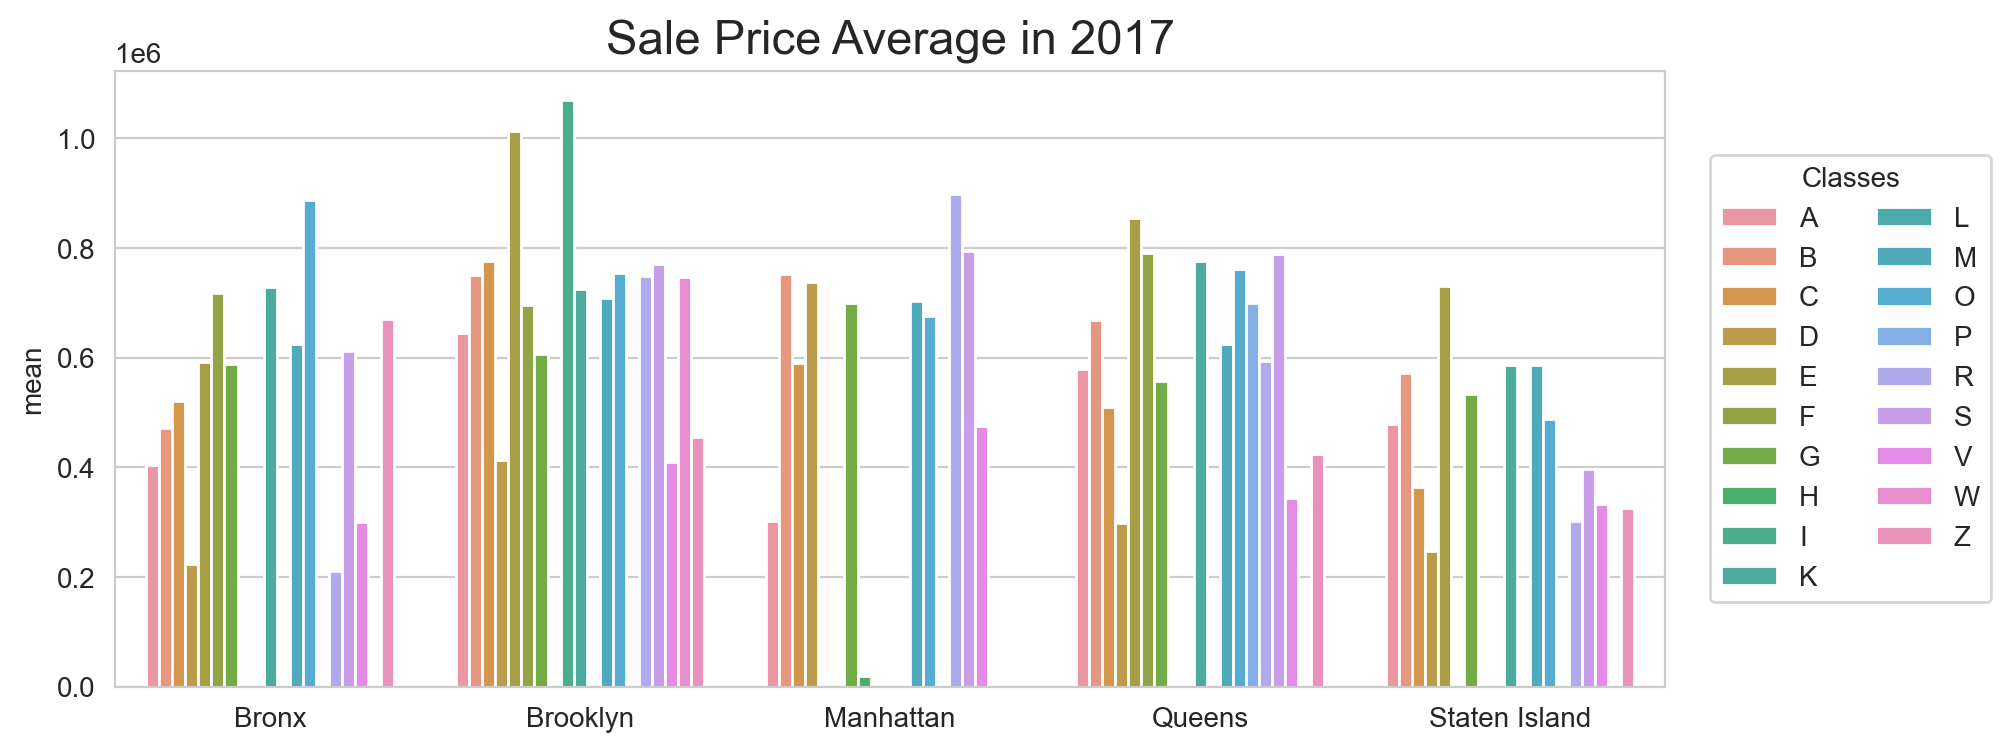

In [152]:
for i in mct["year"].unique():

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(10,4),dpi=200)
        sns.barplot(data=mct[mct["year"] == i],x="borough",y="mean",hue="building_class_at_present",hue_order=np.sort(mct["building_class_at_present"].unique()))
        plt.title(f"Sale Price Average in {i}", fontsize=17)
        plt.xlabel("")
        plt.ylabel("mean")
        plt.legend(bbox_to_anchor=(1.02,0.5),loc="center left",title="Classes",ncol=2)
        plt.show()

### Confidence Intervals of Sample Mean
Sort the 5 highest borough based on sale_price mean from the building_class_at_present category in 2017.

In [153]:
top_5 = mct[mct["year"] == 2017].sort_values("mean",ascending=False).head(5)
top_5

,borough,building_class_at_present,year,mean,median,mode,range,variance,standard_deviation
45,Brooklyn,I,2017,1.070000e+06,1070000.0,975000.0,190000.0,1.805000e+10,134350.288425
39,Brooklyn,E,2017,1.012385e+06,1050000.0,1000000.0,1524000.0,1.886589e+11,434348.849517
90,Manhattan,R,2017,8.978346e+05,895041.0,10.0,1556799.0,1.274793e+11,357042.404200
21,Bronx,O,2017,8.868223e+05,941756.0,450000.0,960000.0,1.339007e+11,365924.399856
106,Queens,E,2017,8.539279e+05,707000.0,1250000.0,1297657.0,2.274052e+11,476870.214816


Slice the datasets based on borough, building_class_at_present, and year that have the top 5 highest averages in sale_price. Then create an array of sale_price.

In [154]:
temp = []
for i,j,k in zip(top_3["borough"],top_3["building_class_at_present"],top_3["year"]):
    temp.append(outliers_removed[(outliers_removed["borough"] == i) & 
                                 (outliers_removed["building_class_at_present"] == j) &
                                 (outliers_removed["year"] == k)])
    
top_5_sale_price = np.array(pd.concat(temp)["sale_price"])
top_5_sale_price

array([ 975000., 1165000.,  585000., ...,  560000.,  475000.,  400530.])

Take 30 random samples and count their means for 500 times. Then add those values into a list called *sample_means*.

In [155]:
np.random.seed(807)
sample_means = []
n = 30 
for sample in range(0,500):
    sample_values = np.random.choice(a = top_3_sale_price, size = n)
    sample_mean = np.mean(sample_values)
    sample_means.append(sample_mean)

Visualize it, and it can be concluded that our data is normally distributed visuality.

c:\Users\acer_\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\acer_\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


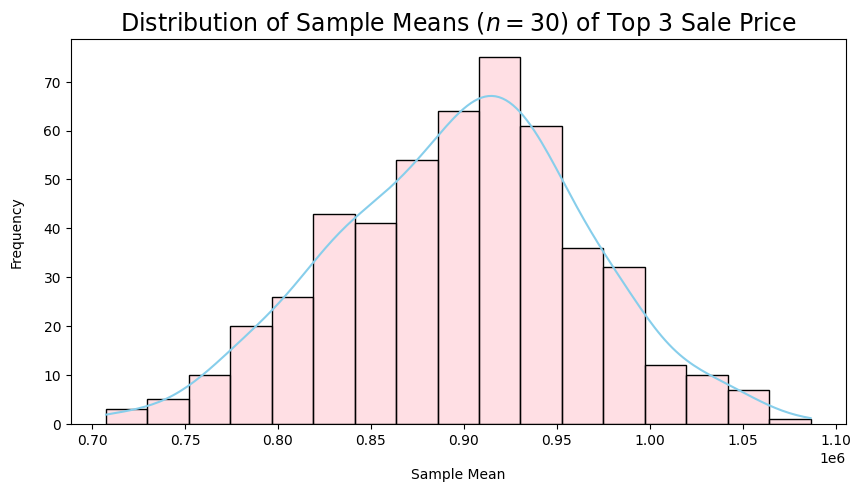

In [156]:
plt.figure(figsize=(10,5),dpi=100)
ax = sns.histplot(data=sample_means,kde=True,color="pink")
ax.lines[0].set_color("skyblue")
plt.title("Distribution of Sample Means ($n=30$) of Top 3 Sale Price", fontsize=17)
plt.xlabel("Sample Mean", labelpad=14)
plt.ylabel("Frequency", labelpad=14);
plt.show()

Calculate the mean of *sample_means*.

In [157]:
mean_of_sample_means = np.mean(sample_means)
mean_of_sample_means

898348.1603333333

Calculate the standard deviation of *sample_means*.

In [158]:
std_of_sample_means = np.std(sample_means)
std_of_sample_means

66829.61900551223

Calculate the standard deviation of *top_5_sale_price*.

In [159]:
pop_std_dev = top_5_sale_price.std()
pop_std_dev

357307.72606824903

Calculate the standard error of *top_5_sale_price*

In [160]:
std_error = np.std(top_5_sale_price) / np.sqrt(n)
std_error

65235.16717948556

Calculate the value of Z-Score

In [161]:
from statistics import NormalDist

confidence = 0.95
z = NormalDist().inv_cdf((1 + confidence) / 2)
z

1.9599639845400536

Calculate the lower limit and upper limit of top_3_sale_price.

In [162]:
lower = sample_mean_mean - (z * std_error)
upper = sample_mean_mean + (z * std_error)

for i,j in zip(["Lower Limit","Upper Limit"],[lower_95,upper_95]):
    print(f"{i}\t= {j}")

Lower Limit	= 768164.7884694256
Upper Limit	= 1023881.9448639078


Visualize the confidence interval of *sample_means*. Based on the plot, it's determined that there's a 95% chance that the mean of a sample of *N* = 25 will be within the blue shaded area. Thus, the probability that the mean of a sample with *N* = 25 will be outside the blue shaded area is 100%-95% = 5%

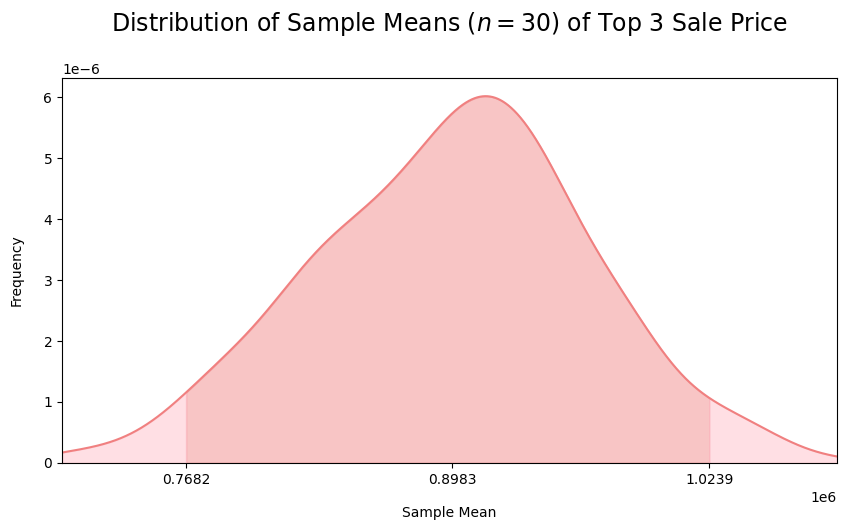

In [163]:
plt.figure(figsize=(10,5),dpi=100)
kde = gaussian_kde(sample_means)
pos = np.linspace(np.min(sample_means), np.max(sample_means), 10000)
plt.plot(pos, kde(pos), color="lightcoral")
shade = np.linspace(lower, upper, 300)

plt.fill_between(shade, kde(shade), alpha=0.45, color='lightcoral')
plt.xticks([lower,mean_of_sample_means,upper])
plt.xlim(xmin=np.min(sample_means),xmax=np.max(sample_means))
plt.ylim(ymin=0)

left = np.linspace(np.min(sample_means),lower,10000)
right = np.linspace(upper,np.max(sample_means),10000)
for i in [left,right]:
    plt.fill_between(i,kde(i),color="pink",alpha=0.5)
    
# plt.text(x=154, y=0.01, horizontalalignment='center', fontsize=3, s="95% of sample means fall within\nthis shaded area of plus or minus\n1.96 z-scores from the mean", bbox=dict(facecolor='whitesmoke', boxstyle="round, pad=0.1"))
plt.title("Distribution of Sample Means ($n=30$) of Top 3 Sale Price", y=1.1, fontsize=17)
plt.xlabel("Sample Mean", labelpad=14)
plt.ylabel("Frequency", labelpad=14);
plt.show()

### Probability Distribution & Hypotesis Testing

#### Hypothesis
- H0 : *top_1_sale_price* data is normally distributed
- H1 : *top_1_sale_price* data is not normally distributed

#### Significance Level
alpha = 5%

#### Test Statistics
Slice the datasets based on borough, building_class_at_present, and year that have the top 1 highest averages in sale_price. Then create an array of sale_price

In [164]:
top_1 = mct[mct["year"] == 2017].sort_values("mean",ascending=False).head(1)
top_1

,borough,building_class_at_present,year,mean,median,mode,range,variance,standard_deviation
45,Brooklyn,I,2017,1070000.0,1070000.0,975000.0,190000.0,1.805000e+10,134350.288425


In [165]:
top_1_sale_price = np.array(df[(df["borough"]==top_1["borough"].iloc[0]) & 
                               (df["building_class_at_present"]==top_1["building_class_at_present"].iloc[0]) &
                               (df["year"]==top_1["year"].iloc[0])]["sale_price"])
top_1_sale_price

array([ 4300000.,  7750184., 11750000.,  5757500., 27813450.,  8550000.,
         975000.,  1165000.])

Visualize the data by histogram, if the dataset is normally distributed and check it using Kolmogorov-Smirnov with  Lilliefors significance correction and Shapiro-Wilk tests formally.

c:\Users\acer_\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\acer_\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


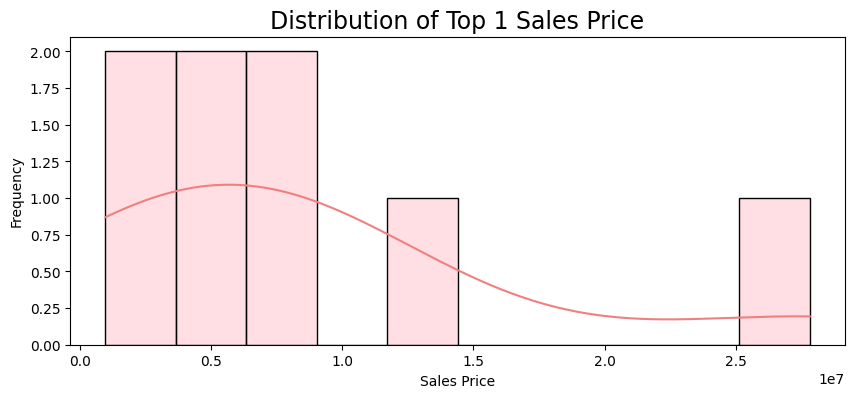

,Kolmogorov-Smirnov,Prob. (K-S),Shapiro-Wilk,Prob. (S-W)
,0.248039,0.171827,0.804168,0.031717


In [166]:
plt.figure(figsize=(10,4), dpi=100)
ax = sns.histplot(data=top_1_sale_price,bins=10,kde=True, color="pink")
ax.lines[0].set_color("lightcoral")
plt.xlabel("Sales Price")
plt.ylabel("Frequency")
plt.title("Distribution of Top 1 Sales Price", fontsize=17)

plt.show()

ks_stat,ks_pval = lilliefors(top_1_sale_price,dist="norm",pvalmethod="approx")
sw_stat,sw_pval = shapiro(top_1_sale_price)
pd.DataFrame({
    "Kolmogorov-Smirnov":[ks_stat],
    "Prob. (K-S)":[ks_pval],
    "Shapiro-Wilk":[sw_stat],
    "Prob. (S-W)":[sw_pval]
},index=[""])

**Conclusion :** Based on the output above, we can conclude that visually of data has a substantial positive skewness. So it can be said, that our data is not normally distributed. On the other hand, the probability of Kolmogorov-Smirnov = 0.172 > alpha (0.05) and the probability of Shapiro-Wilk = 0.03 < alpha (0.05), so that it can be concluded that the data is not normally distributed. Therefore, a transformation is needed for fullfilled the assumption of normally distributed.

In [167]:
transform = np.log10(top_1_sale_price)
transform

array([6.63346846, 6.88931201, 7.07003787, 6.76023395, 7.44425486,
       6.93196611, 5.98900462, 6.06632593])

Repeat the same step before, visualize by histogram to check the normality visually, and check normality formally using Kolomogorov-Smirnov with Lilliefors significance correction and Shapiro-Wilk tests.

c:\Users\acer_\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\acer_\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


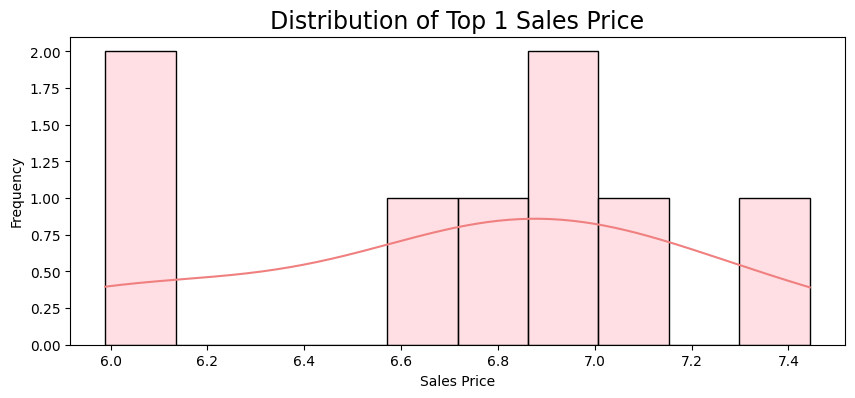

,Kolmogorov-Smirnov,Prob. (K-S),Shapiro-Wilk,Prob. (S-W)
,0.177676,0.645378,0.93502,0.562836


In [168]:
plt.figure(figsize=(10,4), dpi=100)
ax = sns.histplot(data=transform,bins=10,kde=True, color="pink")
ax.lines[0].set_color("lightcoral")
plt.xlabel("Sales Price")
plt.ylabel("Frequency")
plt.title("Distribution of Top 1 Sales Price", fontsize=17)

plt.show()

ks_stat,ks_pval = lilliefors(transform,dist="norm",pvalmethod="approx")
sw_stat,sw_pval = shapiro(transform)
pd.DataFrame({
    "Kolmogorov-Smirnov":[ks_stat],
    "Prob. (K-S)":[ks_pval],
    "Shapiro-Wilk":[sw_stat],
    "Prob. (S-W)":[sw_pval]
},index=[""])

**Conclusion:** Based on the output above, it can be seen visually that the distribution is approximately symmetric, so it seems it's normally distributed. Then formally, the probability of Kolmogorov-Smirnov = 0.645 > alpha (0.05) and the p-values of Shapiro-Wilk = 0.56 > alpha(0.05). So that it can be concluded that the data are normally distributed. Therefore, the assumption of normality visually and formally fulfilled.